In [1]:
import os
import random
import time
from collections import Counter
from io import BytesIO

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
from pydub import AudioSegment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch import nn, optim
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchaudio.transforms import Resample
from tqdm import tqdm

In [2]:
class AphasiaDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_sample_rate=16000, fft_size=512,
                 hop_length=256, win_length=512, min_duration=20, max_duration=30):
        self.root_dir = root_dir
        self.target_sample_rate = target_sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.min_duration = min_duration * 1000  # Convert to milliseconds
        self.max_duration = max_duration * 1000
        self.data = []

        # Load file list from CSV
        df = pd.read_csv(csv_file)

        # Process and segment audio files
        for _, row in df.iterrows():
            file_name, label = row['file_name'], row['label']
            file_path = self.find_audio_file(file_name, label)
            if file_path:
                try:
                    segments = self.process_audio(file_path)
                    self.data.extend([(s, label) for s in segments])
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")

        random.shuffle(self.data)

    def find_audio_file(self, file_name, label):
        """Search for audio file in corresponding folder based on label"""
        folder = "Aphasia" if label == 1 else "Norm"
        file_name = file_name[:-4]  # Remove file extension
        file_path = os.path.join(self.root_dir, folder, f"{file_name}.3gp")
        if os.path.exists(file_path):
            return file_path
        print(f"Warning: {file_name}.3gp not found in {folder} folder.")
        return None

    def process_audio(self, file_path):
        audio = AudioSegment.from_file(file_path, format="3gp")
        duration = len(audio)  # Duration in milliseconds
        segments = []

        # If audio is shorter than minimum duration, use entire audio
        if duration < self.min_duration:
            return [self.create_spectrogram(audio)]

        # Segment audio into chunks
        start = 0
        while start + self.min_duration <= duration:
            segment_duration = min(random.randint(self.min_duration, self.max_duration), duration - start)
            end = start + segment_duration
            segment = audio[start:end]
            spectrogram = self.create_spectrogram(segment)
            if spectrogram is not None:
                segments.append(spectrogram)
            start = end
        return segments

    def create_spectrogram(self, segment):
        try:
            # Convert audio segment to buffer
            buffer = BytesIO()
            segment.export(buffer, format="wav")
            buffer.seek(0)
            
            # Load audio and resample if needed
            waveform, sample_rate = torchaudio.load(buffer)

            if sample_rate != self.target_sample_rate:
                resampler = Resample(sample_rate, self.target_sample_rate)
                waveform = resampler(waveform)

            # Skip if audio is too short
            if waveform.shape[1] < self.fft_size:
                return None

            # Create spectrogram using STFT
            y = waveform.numpy().squeeze()
            spectrogram = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
            mag = np.abs(spectrogram).astype(np.float32)
            return torch.tensor(mag.T).unsqueeze(0)  # Shape: (1, T, F)
        except Exception as e:
            print(f"Spectrogram error: {str(e)}")
            return None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrogram, label = self.data[idx]
        return spectrogram, torch.tensor(label, dtype=torch.long)


def pad_sequence(batch):
    """Pad spectrograms in batch to same length"""
    if not batch:
        return torch.zeros(0), torch.zeros(0)

    spectrograms, labels = zip(*batch)
    
    # Find maximum sequence length in batch
    max_len = max(s.shape[1] for s in spectrograms)
    freq_bins = spectrograms[0].shape[2]

    # Create padded tensor
    padded = torch.zeros(len(spectrograms), 1, max_len, freq_bins)
    for i, s in enumerate(spectrograms):
        padded[i, :, :s.shape[1], :] = s

    return padded, torch.stack(labels)

Sampler(because of class imbalance)

In [3]:
root_dir = "/home/aysurkov/aphasia"
train_dataset = AphasiaDataset("splited_data/train_filenames.csv", root_dir)
test_dataset = AphasiaDataset("splited_data/test_filenames.csv", root_dir)
val_dataset = AphasiaDataset("splited_data/val_filenames.csv", root_dir)

# balancing classes for train
train_labels = [label for _, label in train_dataset.data]
class_counts = Counter(train_labels)
if len(class_counts) < 2:
    raise ValueError("One of the classes is missing in the training set")

class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for _, label in train_dataset.data]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler, collate_fn=pad_sequence, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=pad_sequence, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=pad_sequence, drop_last=True)

In [5]:
print(len(train_dataloader), len(test_dataloader), len(val_dataloader))

149 58 50


In [6]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  # Conv 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 3
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # Conv 5
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = self.fc_layers(x)
        return x

In [7]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    acc = 0.0
    prec = 0.0
    rec = 0.0

    with torch.no_grad():
        for spectrograms, labels in tqdm(dataloader, desc="Validation"):
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            outputs = model(spectrograms)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  
            labels = labels.cpu().numpy()
            acc += accuracy_score(labels, preds)
            prec += precision_score(labels, preds, zero_division=1)
            rec += recall_score(labels, preds, zero_division=1)

    acc = acc / len(dataloader)
    prec = prec / len(dataloader)
    rec = rec / len(dataloader)

    return acc, prec, rec

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = CNNModel(num_classes=2).to(device)

criterion = criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 30
los, ac, pre, re = [], [], [], []

Let's train model(best params; saving weights)

In [9]:
train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
epochs = []

best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_list = []

    for spectrograms, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        spectrograms, labels = spectrograms.to(device), labels.long().to(device)

        outputs = model(spectrograms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

    avg_train_loss = torch.tensor(train_loss_list).mean().item()
    train_losses.append(avg_train_loss)

    # Validation after each epoch
    model.eval()
    acc, prec, rec = evaluate_model(model, val_dataloader, criterion, device)
    scheduler.step()

    # Save validation metrics
    val_accuracies.append(acc)
    val_precisions.append(prec)
    val_recalls.append(rec)
    epochs.append(epoch)

    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), os.path.join("/home/aysurkov/aphasia/model/", f"aphasia_final_{epoch}.pt"))
        print(f"New best model - {epoch} epoch saved!")

# Final evaluation on test set - will do again with best ver
acc, prec, rec = evaluate_model(model, test_dataloader, criterion, device)
print(f"Test Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

Validation: 100%|██████████| 50/50 [00:02<00:00, 24.64it/s]


Epoch 1/30 - Train Loss: 0.4943
Validation Metrics - Accuracy: 0.5925, Precision: 0.9960, Recall: 0.5313
New best model - 1 epoch saved!


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.38it/s]


Epoch 2/30 - Train Loss: 0.3978
Validation Metrics - Accuracy: 0.9050, Precision: 0.9018, Recall: 1.0000
New best model - 2 epoch saved!


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.35it/s]


Epoch 3/30 - Train Loss: 0.4041
Validation Metrics - Accuracy: 0.9225, Precision: 0.9867, Recall: 0.9234
New best model - 3 epoch saved!


Validation: 100%|██████████| 50/50 [00:02<00:00, 23.94it/s]


Epoch 4/30 - Train Loss: 0.3621
Validation Metrics - Accuracy: 0.6325, Precision: 0.9960, Recall: 0.5738


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.24it/s]


Epoch 5/30 - Train Loss: 0.3424
Validation Metrics - Accuracy: 0.7525, Precision: 1.0000, Recall: 0.7104


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.37it/s]


Epoch 6/30 - Train Loss: 0.3071
Validation Metrics - Accuracy: 0.7925, Precision: 1.0000, Recall: 0.7568


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.05it/s]


Epoch 7/30 - Train Loss: 0.3171
Validation Metrics - Accuracy: 0.8200, Precision: 0.9971, Recall: 0.7919


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.49it/s]


Epoch 8/30 - Train Loss: 0.2730
Validation Metrics - Accuracy: 0.9350, Precision: 0.9848, Recall: 0.9439
New best model - 8 epoch saved!


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.32it/s]


Epoch 9/30 - Train Loss: 0.2725
Validation Metrics - Accuracy: 0.9200, Precision: 0.9935, Recall: 0.9180


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.32it/s]


Epoch 10/30 - Train Loss: 0.2601
Validation Metrics - Accuracy: 0.9500, Precision: 0.9742, Recall: 0.9704
New best model - 10 epoch saved!


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.44it/s]


Epoch 11/30 - Train Loss: 0.2570
Validation Metrics - Accuracy: 0.9475, Precision: 0.9821, Recall: 0.9604


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Epoch 12/30 - Train Loss: 0.2404
Validation Metrics - Accuracy: 0.9450, Precision: 0.9873, Recall: 0.9518


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.21it/s]


Epoch 13/30 - Train Loss: 0.2254
Validation Metrics - Accuracy: 0.9675, Precision: 0.9821, Recall: 0.9804
New best model - 13 epoch saved!


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Epoch 14/30 - Train Loss: 0.2499
Validation Metrics - Accuracy: 0.9475, Precision: 0.9816, Recall: 0.9600


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.12it/s]


Epoch 15/30 - Train Loss: 0.2645
Validation Metrics - Accuracy: 0.9500, Precision: 0.9486, Recall: 1.0000


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.37it/s]


Epoch 16/30 - Train Loss: 0.2699
Validation Metrics - Accuracy: 0.9375, Precision: 0.9861, Recall: 0.9460


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.37it/s]


Epoch 17/30 - Train Loss: 0.2744
Validation Metrics - Accuracy: 0.8250, Precision: 1.0000, Recall: 0.7927


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.09it/s]


Epoch 18/30 - Train Loss: 0.2940
Validation Metrics - Accuracy: 0.9000, Precision: 0.9656, Recall: 0.9225


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.32it/s]


Epoch 19/30 - Train Loss: 0.3058
Validation Metrics - Accuracy: 0.9725, Precision: 0.9820, Recall: 0.9857
New best model - 19 epoch saved!


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.37it/s]


Epoch 20/30 - Train Loss: 0.2950
Validation Metrics - Accuracy: 0.9000, Precision: 0.9975, Recall: 0.8865


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.10it/s]


Epoch 21/30 - Train Loss: 0.2847
Validation Metrics - Accuracy: 0.7250, Precision: 0.9967, Recall: 0.6827


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.40it/s]


Epoch 22/30 - Train Loss: 0.2804
Validation Metrics - Accuracy: 0.9675, Precision: 0.9767, Recall: 0.9861


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.44it/s]


Epoch 23/30 - Train Loss: 0.2923
Validation Metrics - Accuracy: 0.9725, Precision: 0.9754, Recall: 0.9943


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.01it/s]


Epoch 24/30 - Train Loss: 0.2483
Validation Metrics - Accuracy: 0.9100, Precision: 0.9975, Recall: 0.8980


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.40it/s]


Epoch 25/30 - Train Loss: 0.2391
Validation Metrics - Accuracy: 0.9000, Precision: 0.9902, Recall: 0.8926


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.39it/s]


Epoch 26/30 - Train Loss: 0.2451
Validation Metrics - Accuracy: 0.8825, Precision: 0.8811, Recall: 1.0000


Validation: 100%|██████████| 50/50 [00:02<00:00, 24.96it/s]


Epoch 27/30 - Train Loss: 0.2159
Validation Metrics - Accuracy: 0.9250, Precision: 0.9583, Recall: 0.9595


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.42it/s]


Epoch 28/30 - Train Loss: 0.2006
Validation Metrics - Accuracy: 0.9625, Precision: 0.9746, Recall: 0.9832


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.32it/s]


Epoch 29/30 - Train Loss: 0.1713
Validation Metrics - Accuracy: 0.9425, Precision: 0.9906, Recall: 0.9400


Validation: 100%|██████████| 50/50 [00:01<00:00, 25.04it/s]


Epoch 30/30 - Train Loss: 0.1694
Validation Metrics - Accuracy: 0.9225, Precision: 0.9902, Recall: 0.9189


Validation: 100%|██████████| 57/57 [00:02<00:00, 24.96it/s]

Test Metrics - Accuracy: 0.9298, Precision: 0.9711, Recall: 0.9488


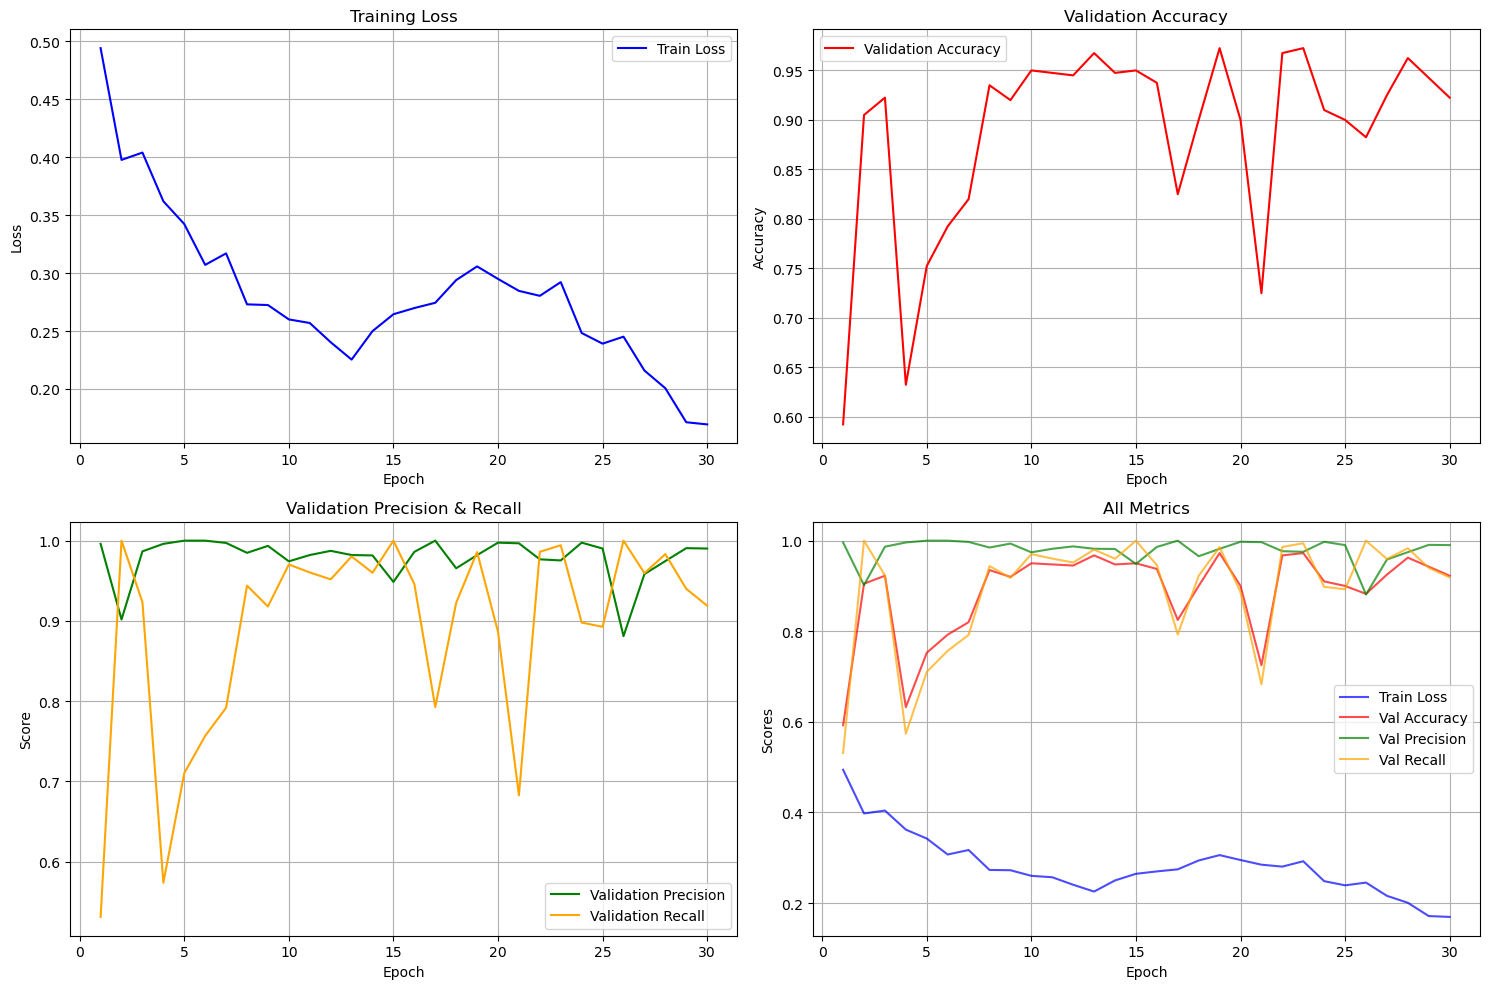

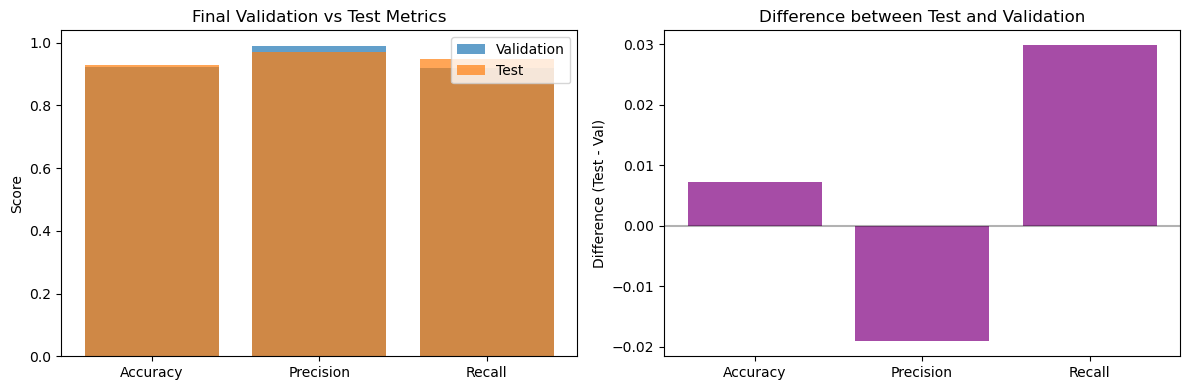

In [10]:

# Plotting training and validation metrics
plt.figure(figsize=(15, 10))

# Plot 1: Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot 3: Validation Precision and Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, val_precisions, 'g-', label='Validation Precision')
plt.plot(epochs, val_recalls, 'orange', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Precision & Recall')
plt.legend()
plt.grid(True)

# Plot 4: All metrics together
plt.subplot(2, 2, 4)
plt.plot(epochs, train_losses, 'b-', label='Train Loss', alpha=0.7)
plt.plot(epochs, val_accuracies, 'r-', label='Val Accuracy', alpha=0.7)
plt.plot(epochs, val_precisions, 'g-', label='Val Precision', alpha=0.7)
plt.plot(epochs, val_recalls, 'orange', label='Val Recall', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.title('All Metrics')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

metrics_names = ['Accuracy', 'Precision', 'Recall']
val_metrics = [val_accuracies[-1], val_precisions[-1], val_recalls[-1]]  # Last validation values
test_metrics = [acc, prec, rec]

x = range(len(metrics_names))
plt.subplot(1, 2, 1)
plt.bar(x, val_metrics, alpha=0.7, label='Validation')
plt.bar(x, test_metrics, alpha=0.7, label='Test')
plt.xticks(x, metrics_names)
plt.ylabel('Score')
plt.title('Final Validation vs Test Metrics')
plt.legend()

# Bar chart showing differences
plt.subplot(1, 2, 2)
difference = [test - val for test, val in zip(test_metrics, val_metrics)]
plt.bar(x, difference, color='purple', alpha=0.7)
plt.xticks(x, metrics_names)
plt.ylabel('Difference (Test - Val)')
plt.title('Difference between Test and Validation')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
state_dict = torch.load('/home/aysurkov/aphasia/model/aphasia_final_19.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
acc, prec, rec = evaluate_model(model, test_dataloader, criterion, device)
print(f"Test Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

acc, prec, rec = evaluate_model(model, val_dataloader, criterion, device)
print(f"Validation Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

Validation: 100%|██████████| 58/58 [00:03<00:00, 17.22it/s]


Test Metrics - Accuracy: 0.9397, Precision: 0.9524, Recall: 0.9774


Validation: 100%|██████████| 50/50 [00:02<00:00, 22.01it/s]

Validation Metrics - Accuracy: 0.9700, Precision: 0.9783, Recall: 0.9856


Aggregation by participant:

In [14]:
@torch.no_grad()
def evaluate_by_participant(
    model,
    csv_file: str,
    root_dir: str,
    dataset_ref: AphasiaDataset,
    device: torch.device,
    batch_size: int = 32,
    zero_division: int = 1,
):
    """
    Calculates metrics at the participant level.
    Steps:
      1) Read CSV (file_name, label),
      2) Group by participant_id (using first two tokens in file name separated by '-'),
      3) For each original file, slice into segments using the same method as in the dataset,
      4) Run all file segments through the model, average probabilities (softmax) -> file prediction,
      5) Average file probabilities within participant -> participant prediction,
      6) Calculate metrics by participants.
    """
    model.eval()

    df = pd.read_csv(csv_file).copy()

    def _pid(fn: str) -> str:
        parts = str(fn).split("-")
        return parts[0] + parts[1] if len(parts) >= 2 else parts[0]

    df["participant_id"] = df["file_name"].apply(_pid)

    part_probs = {}    # participant_id -> list of tensors (probabilities) per files
    part_labels = {}

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Per-file inference for participant metrics"):
        file_name = row["file_name"]
        label = int(row["label"])
        pid = row["participant_id"]

        file_path = dataset_ref.find_audio_file(file_name, label)
        if file_path is None:
            continue

        try:
            segments = dataset_ref.process_audio(file_path)
        except Exception as e:
            print(f"[WARN] Skipped {file_path} due to error: {e}")
            continue

        if not segments:
            continue

        max_len = max(seg.shape[1] for seg in segments)  # (1, T, F)
        freq_bins = segments[0].shape[2]
        batch = torch.zeros(len(segments), 1, max_len, freq_bins, dtype=torch.float32)
        for i, seg in enumerate(segments):
            t = seg.shape[1]
            batch[i, :, :t, :] = seg
        batch = batch.to(device)

        
        outputs = model(batch)                    # (num_segments, num_classes)
        seg_probs = torch.softmax(outputs, dim=1) # (num_segments, num_classes)
        file_probs = seg_probs.mean(dim=0)        # (num_classes,)

        if pid not in part_probs:
            part_probs[pid] = []
            part_labels[pid] = label
        else:
            if part_labels[pid] != label:
                print(f"[WARN] Participant {pid} has inconsistent labels in CSV. Using the first seen label {part_labels[pid]}.")

        part_probs[pid].append(file_probs.detach().cpu())

    y_true, y_pred = [], []
    for pid, probs_list in part_probs.items():
        if not probs_list:
            continue
        
        mean_probs = torch.stack(probs_list, dim=0).mean(dim=0)  # (num_classes,)
        pred = int(mean_probs.argmax().item())
        y_pred.append(pred)
        y_true.append(int(part_labels[pid]))

    if len(y_true) == 0:
        print("[ERROR] No participant-level predictions could be computed.")
        return None

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=zero_division)
    rec = recall_score(y_true, y_pred, zero_division=zero_division)
    f1 = f1_score(y_true, y_pred, zero_division=zero_division)

    print("\nParticipant-level metrics:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1       : {f1:.4f}")
    print("\nClassification report (participant-level):")
    print(classification_report(y_true, y_pred, zero_division=zero_division))

    return {
        "y_true": np.array(y_true),
        "y_pred": np.array(y_pred),
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
    }


In [16]:
class AphasiaDataset(Dataset):
    def __init__(self, csv_file, root_dir, target_sample_rate=16000, fft_size=512, 
                 hop_length=256, win_length=512, min_duration=10, max_duration=15):
        self.root_dir = root_dir
        self.target_sample_rate = target_sample_rate
        self.fft_size = fft_size
        self.hop_length = hop_length
        self.win_length = win_length
        self.min_duration = min_duration * 1000  # milliseconds
        self.max_duration = max_duration * 1000
        self.data = []
        self.is_validation = "val_filenames.csv" in csv_file  # Check if the dataset is validation

        df = pd.read_csv(csv_file)

        for _, row in df.iterrows():
            file_name, label = row['file_name'], row['label']
            file_path = self.find_audio_file(file_name, label)
            if file_path:
                try:
                    segments = self.process_audio(file_path)
                    self.data.extend([(s, label) for s in segments])
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
        
        random.shuffle(self.data)
    
    def find_audio_file(self, file_name, label):
        folder = "Aphasia" if label == 1 else "Norm"
        file_name = file_name[:-4]
        file_path = os.path.join(self.root_dir, folder, f"{file_name}.3gp")
        if os.path.exists(file_path):
            return file_path
        print(f"Warning: {file_name}.3gp not found in {folder} folder.")
        return None

    def process_audio(self, file_path):
        audio = AudioSegment.from_file(file_path, format="3gp")
        if self.is_validation:
            return [self.create_spectrogram(audio)]  # Return the audio as a whole
        
        duration = len(audio)
        segments = []

        if duration < self.min_duration:
            return [self.create_spectrogram(audio)]

        start = 0
        while start + self.min_duration <= duration:
            segment_duration = min(random.randint(self.min_duration, self.max_duration), duration - start)
            end = start + segment_duration
            segment = audio[start:end]
            spectrogram = self.create_spectrogram(segment)
            if spectrogram is not None:
                segments.append(spectrogram)
            start = end
        return segments

    def create_spectrogram(self, segment):
        try:
            buffer = BytesIO()
            segment.export(buffer, format="wav")
            buffer.seek(0)
            waveform, sample_rate = torchaudio.load(buffer)
            
            if sample_rate != self.target_sample_rate:
                resampler = Resample(sample_rate, self.target_sample_rate)
                waveform = resampler(waveform)
            
            if waveform.shape[1] < self.fft_size:
                return None
            
            y = waveform.numpy().squeeze()
            spectrogram = librosa.stft(y, n_fft=self.fft_size, hop_length=self.hop_length, win_length=self.win_length)
            mag = np.abs(spectrogram).astype(np.float32)
            return torch.tensor(mag.T).unsqueeze(0)  # (1, T, F)
        except Exception as e:
            print(f"Spectrogram error: {str(e)}")
            return None


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrogram, label = self.data[idx]
        return spectrogram, torch.tensor(label, dtype=torch.long)

def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)
    
    spectrograms, labels = zip(*batch)
    max_len = max(s.shape[1] for s in spectrograms)
    freq_bins = spectrograms[0].shape[2]
    
    padded = torch.zeros(len(spectrograms), 1, max_len, freq_bins)
    for i, s in enumerate(spectrograms):
        padded[i, :, :s.shape[1], :] = s
    
    return padded, torch.stack(labels) 


In [17]:
root_dir = "/home/aysurkov/aphasia/"
val_dataset = AphasiaDataset("splited_data/val_filenames.csv", root_dir)
test_dataset = AphasiaDataset("splited_data/test_filenames.csv", root_dir)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=pad_sequence, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=pad_sequence, drop_last=True)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn=pad_sequence, drop_last=True)
print(len(val_dataloader))
print(len(test_dataloader))

79
481


Similarly, initialize the best model version so far and validate on the original validation audio files:

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = CNNModel(num_classes=2).to(device)

state_dict = torch.load('/home/aysurkov/aphasia/model/aphasia_final_19.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
acc, prec, rec = evaluate_model(model, val_dataloader, criterion, device)
print(f"Validation Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

acc, prec, rec = evaluate_model(model, test_dataloader, criterion, device)
print(f"Test Metrics - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

Validation: 100%|██████████| 204/204 [00:02<00:00, 74.53it/s]


Validation Metrics - Accuracy: 0.9779, Precision: 0.9779, Recall: 0.9926


Validation: 100%|██████████| 229/229 [00:02<00:00, 78.35it/s]

Test Metrics - Accuracy: 0.9476, Precision: 0.9520, Recall: 0.9891


Aggregation by participant:

In [21]:

@torch.no_grad()
def evaluate_by_participant(
    model,
    csv_file: str,
    root_dir: str,
    dataset_ref: AphasiaDataset,
    device: torch.device,
    batch_size: int = 32,
    zero_division: int = 1,
):
    """
    Calculates metrics at the participant level.
    Steps:
      1) Read CSV (file_name, label),
      2) Group by participant_id (using first two tokens in file name separated by '-'),
      3) For each original file, slice into segments using the same method as in the dataset,
      4) Run all file segments through the model, average probabilities (softmax) -> file prediction,
      5) Average file probabilities within participant -> participant prediction,
      6) Calculate metrics by participants.
    """
    model.eval()

    df = pd.read_csv(csv_file).copy()

    def _pid(fn: str) -> str:
        parts = str(fn).split("-")
        return parts[0] + parts[1] if len(parts) >= 2 else parts[0]

    df["participant_id"] = df["file_name"].apply(_pid)

    part_probs = {}    # participant_id -> list of tensors (probabilities) per files
    part_labels = {}

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Per-file inference for participant metrics"):
        file_name = row["file_name"]
        label = int(row["label"])
        pid = row["participant_id"]

        file_path = dataset_ref.find_audio_file(file_name, label)
        if file_path is None:
            continue

        try:
            segments = dataset_ref.process_audio(file_path)
        except Exception as e:
            print(f"[WARN] Skipped {file_path} due to error: {e}")
            continue

        if not segments:
            continue

        max_len = max(seg.shape[1] for seg in segments)  # (1, T, F)
        freq_bins = segments[0].shape[2]
        batch = torch.zeros(len(segments), 1, max_len, freq_bins, dtype=torch.float32)
        for i, seg in enumerate(segments):
            t = seg.shape[1]
            batch[i, :, :t, :] = seg
        batch = batch.to(device)

        
        outputs = model(batch)                    # (num_segments, num_classes)
        seg_probs = torch.softmax(outputs, dim=1) # (num_segments, num_classes)
        file_probs = seg_probs.mean(dim=0)        # (num_classes,)

        if pid not in part_probs:
            part_probs[pid] = []
            part_labels[pid] = label
        else:
            if part_labels[pid] != label:
                print(f"[WARN] Participant {pid} has inconsistent labels in CSV. Using the first seen label {part_labels[pid]}.")

        part_probs[pid].append(file_probs.detach().cpu())

    y_true, y_pred = [], []
    for pid, probs_list in part_probs.items():
        if not probs_list:
            continue
        
        mean_probs = torch.stack(probs_list, dim=0).mean(dim=0)  # (num_classes,)
        pred = int(mean_probs.argmax().item())
        y_pred.append(pred)
        y_true.append(int(part_labels[pid]))

    if len(y_true) == 0:
        print("[ERROR] No participant-level predictions could be computed.")
        return None

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=zero_division)
    rec = recall_score(y_true, y_pred, zero_division=zero_division)
    f1 = f1_score(y_true, y_pred, zero_division=zero_division)

    print("\nParticipant-level metrics:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1       : {f1:.4f}")
    print("\nClassification report (participant-level):")
    print(classification_report(y_true, y_pred, zero_division=zero_division))

    return {
        "y_true": np.array(y_true),
        "y_pred": np.array(y_pred),
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
    }


In [22]:
 test = evaluate_by_participant(
        model=model,
        csv_file="/home/aysurkov/aphasia/splited_data/test_filenames.csv",
        root_dir=root_dir,
        dataset_ref=train_dataset, 
        device=device,
    )

val = evaluate_by_participant(
    model=model,
    csv_file="/home/aysurkov/aphasia/splited_data/val_filenames.csv",
    root_dir=root_dir,
    dataset_ref=train_dataset,
    device=device,
)

Per-file inference for participant metrics: 100%|██████████| 172/172 [00:56<00:00,  3.05it/s]



Participant-level metrics:
  Accuracy : 0.9167
  Precision: 0.9091
  Recall   : 0.9804
  F1       : 0.9434

Classification report (participant-level):
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        21
           1       0.91      0.98      0.94        51

    accuracy                           0.92        72
   macro avg       0.93      0.87      0.89        72
weighted avg       0.92      0.92      0.91        72



Per-file inference for participant metrics: 100%|██████████| 159/159 [00:50<00:00,  3.16it/s]


Participant-level metrics:
  Accuracy : 0.9718
  Precision: 0.9623
  Recall   : 1.0000
  F1       : 0.9808

Classification report (participant-level):
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.96      1.00      0.98        51

    accuracy                           0.97        71
   macro avg       0.98      0.95      0.96        71
weighted avg       0.97      0.97      0.97        71

